# Data Science Capstone Final Project:
### Exploring the surrounding areas of schools in the capital of Sweden, Stockholm

#### Introduction/Business Problem

An area with schools can be appealing to many businesses that not only want to expand, but also increase their profits. After a long day at school, the students might decide to go for food with friends or family. A school with a lot of students for instance, could be a target for building a new bakery or a restaurant. 

At the same time, getting information about what exists around a school can be signifant for parents, who want to choose a school for their kids that provides a lot of places where their kids and themselves can relax before or after school.

My goal with this project is to find which are the most common venues next to schools around Stockholm and if there is any correlation with the number of enrolled students. Furthermore, I would like to investigate if there is a specific pattern with the most common venues that are somehow related to presence of schools. 

#### Data
The school data were provided from an open source data portal: https://dataportalen.stockholm.se/. They were in a form of a dbf database, so the simpledbf library was utilized so that to create a pandas DataFrame for further analysis. 

### Libraries

In [1]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes 
!pip install simpledbf
!pip install pyproj==2.6.1

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  openssl                                 1.1.1g-h516909a_0 --> 1.1.1g-h516909a_1



openssl-1.1.1g       | 2.1 MB    | #####

In [2]:
import pandas as pd
from pandas.io.json import json_normalize
from simpledbf import Dbf5

import folium # map rendering library
from geopy.geocoders import Nominatim 

from pyproj import CRS

from pyproj import Transformer

In [3]:
# Stockholm's location

latitude = 59.3293
longitude = 18.0686
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3293, 18.0686.


In [4]:
### Stockholm's map

map_sweden = folium.Map(location=[latitude, longitude], zoom_start=12)
   
map_sweden

### Load the school DataSet

In [5]:
dbf = Dbf5('alla_skolor_1920_elevantal.dbf')

df = dbf.to_dataframe() # transform to pandas DataFrame

In [6]:
df.head()

,SDO,REGI,SKOLENHETS,Skolenhe_1,SKOLA,Arskurs,Elevanal19,Särskola,Särskola_,X_North,Y_East,NOTE,ADRESS,POSTNR,POSTORT,BESÖKSADR,Kommentar
0,Bromma,Kommunala grundskolor,44673074,Abrahamsbergsskolan,Abrahamsbergsskolan,F-9,678,0,0,6579984.0,147176.0,NaN,Gustav III:s väg 2-10,16830,BROMMA,NaN,NaN
1,Norrmalm,Kommunala grundskolor,99648792,Adolf Fredriks musikklasser,Adolf Fredriks Musikklasser,4-9,1120,0,0,6580259.0,152895.0,NaN,Box 6267,10231,STOCKHOLM,NaN,NaN
2,Bromma,Kommunala grundskolor,41285467,Adolfsbergsskolan,Adolfsbergsskolan,F-1,132,0,0,6582511.0,147360.0,NaN,Gårdsfogdevägen 18 B,16867,BROMMA,NaN,NaN
3,Rinkeby-Kista,Fristående grundskolor,17526606,Akademiska Skolan i Kista,Akademiska skolan i Kista-Husby,F-6,35,0,0,6588485.0,145913.0,NaN,Lofotengatan 32-34,16433,KISTA,NaN,NaN
4,Rinkeby-Kista,Kommunala grundskolor,37796564,Akalla grundskola F-9,Akalla grundskola F-9,F-9,498,1,0,6588999.0,144905.0,NaN,Mariehamnsgatan 3-5,16471,KISTA,NaN,NaN


In [7]:
df.shape

(375, 17)

In [8]:
len(df.SKOLA.unique())

372

The dataFrame has 375 entries (372 different schools) and 17 features (some features will be filtered out later). 
1. The most important ones are SDO- which is the region where the school is located, 
2. REGI- if the school is municipal or stand-alone,
3. SKOLA-The name of the school, 
4. Årskurs- the school grade that the data come from, 
5. Elevanal19- the number of enrolled students for 2019-20, 
6. X_North & Y_East- the coordinates in SWEREF99 1800 coordinate system (Transformation to WGS84 standard coordination system is necessary to work both with the Foursquare API and Folium library)

### Drop extra Columns

In [9]:
df.columns

Index(['SDO', 'REGI', 'SKOLENHETS', 'Skolenhe_1', 'SKOLA', 'Arskurs',
       'Elevanal19', 'Särskola', 'Särskola_', 'X_North', 'Y_East', 'NOTE',
       'ADRESS', 'POSTNR', 'POSTORT', 'BESÖKSADR', 'Kommentar'],
      dtype='object')

In [10]:
drop_col = [df.columns[2], df.columns[3], df.columns[7], df.columns[8], df.columns[11], df.columns[12], df.columns[13], 
            df.columns[14], df.columns[15], df.columns[16]]

In [11]:
drop_col

['SKOLENHETS',
 'Skolenhe_1',
 'Särskola',
 'Särskola_',
 'NOTE',
 'ADRESS',
 'POSTNR',
 'POSTORT',
 'BESÖKSADR',
 'Kommentar']

In [12]:
df.drop(drop_col, axis = 1, inplace = True)

In [13]:
df

,SDO,REGI,SKOLA,Arskurs,Elevanal19,X_North,Y_East
0,Bromma,Kommunala grundskolor,Abrahamsbergsskolan,F-9,678,6579984.0,147176.0
1,Norrmalm,Kommunala grundskolor,Adolf Fredriks Musikklasser,4-9,1120,6580259.0,152895.0
2,Bromma,Kommunala grundskolor,Adolfsbergsskolan,F-1,132,6582511.0,147360.0
3,Rinkeby-Kista,Fristående grundskolor,Akademiska skolan i Kista-Husby,F-6,35,6588485.0,145913.0
4,Rinkeby-Kista,Kommunala grundskolor,Akalla grundskola F-9,F-9,498,6588999.0,144905.0
...,...,...,...,...,...,...,...
370,Bromma,Kommunala grundskolor,Äppelviksskolan,6-9,665,6578699.0,148593.0
371,Enskede-Årsta-Vantör,Kommunala grundskolor,Örbyskolan,F-9,738,6573264.0,151538.0
372,Enskede-Årsta-Vantör,Kommunala grundskolor,Östbergaskolan,F-6,197,6574889.0,151929.0
373,Östermalm,Kommunala grundskolor,Östermalmsskolan,F-6,546,6580245.0,155423.0


### Check for missing values

In [14]:
df.isnull().sum(axis = 0)

SDO           0
REGI          0
SKOLA         0
Arskurs       1
Elevanal19    0
X_North       0
Y_East        0
dtype: int64

In [15]:
bool_series = pd.isnull(df['Arskurs'])  

In [16]:
# filtering data  
df[bool_series]  

,SDO,REGI,SKOLA,Arskurs,Elevanal19,X_North,Y_East
114,Östermalm,Kommunala grundskolor,Hjorthagens skola,NaN,397,6582118.0,155563.0


### Fill NA with Missing since we do not particularly need this information

In [17]:
df.Arskurs.fillna('Missing', inplace = True) # Fill NA with the string missing

In [18]:
sum(df.isnull().sum(axis = 0))

0

In [19]:
# filtering data  
df[bool_series] 

,SDO,REGI,SKOLA,Arskurs,Elevanal19,X_North,Y_East
114,Östermalm,Kommunala grundskolor,Hjorthagens skola,Missing,397,6582118.0,155563.0


### Transform x,y coordinates from SWEREF99 1800 to standard WGS84 system

In [20]:
crs_4326 = CRS.from_epsg(4326) #WGS84
crs_3011 = CRS.from_epsg(3011) # SWEREF 99 1800

transformer = Transformer.from_crs(crs_3011, crs_4326)
transformer = Transformer.from_crs(3011, 4326)
transformer = Transformer.from_crs("EPSG:3011", "EPSG:4326")


In [21]:
def transformation(X,Y):
    Xnew, Ynew = transformer.transform(X,Y)
    return Xnew, Ynew
    

In [22]:
df.X_North, df.Y_East = map(list, zip(*[coord for coord in df.apply(lambda w: transformation(w.X_North,w.Y_East), axis = 1)]))

In [23]:
df

,SDO,REGI,SKOLA,Arskurs,Elevanal19,X_North,Y_East
0,Bromma,Kommunala grundskolor,Abrahamsbergsskolan,F-9,678,59.334960,17.950383
1,Norrmalm,Kommunala grundskolor,Adolf Fredriks Musikklasser,4-9,1120,59.337428,18.050868
2,Bromma,Kommunala grundskolor,Adolfsbergsskolan,F-1,132,59.357645,17.953585
3,Rinkeby-Kista,Fristående grundskolor,Akademiska skolan i Kista-Husby,F-6,35,59.411259,17.928031
4,Rinkeby-Kista,Kommunala grundskolor,Akalla grundskola F-9,F-9,498,59.415862,17.910269
...,...,...,...,...,...,...,...
370,Bromma,Kommunala grundskolor,Äppelviksskolan,6-9,665,59.323432,17.975288
371,Enskede-Årsta-Vantör,Kommunala grundskolor,Örbyskolan,F-9,738,59.274644,18.026974
372,Enskede-Årsta-Vantör,Kommunala grundskolor,Östbergaskolan,F-6,197,59.289229,18.033847
373,Östermalm,Kommunala grundskolor,Östermalmsskolan,F-6,546,59.337277,18.095287


In [24]:
map_stockholm = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, sdo, school in zip(df['X_North'], df['Y_East'], df['SDO'], df['SKOLA']):
    label = '{}{}'.format(sdo, school)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#E52B50',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stockholm)  
    
map_stockholm

In [25]:
## Find venues with Foursquare API
CLIENT_ID = '0WC5F0U5FBMNZZTRU2JNK2DPMXAMCZIALHOKO5D3GLPBW3Q3' # your Foursquare ID
CLIENT_SECRET = 'TPBRN5MV3PU5M3TFKE40KGHFBSDLZB5ZABQZLVLABPX3MRQ1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
limit = 100

Your credentails:
CLIENT_ID: 0WC5F0U5FBMNZZTRU2JNK2DPMXAMCZIALHOKO5D3GLPBW3Q3
CLIENT_SECRET:TPBRN5MV3PU5M3TFKE40KGHFBSDLZB5ZABQZLVLABPX3MRQ1


In [26]:
import requests

In [27]:
def getNearbyVenues(names, neigh, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, n, lat, lng in zip(names, neigh, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            n,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['School', 
                  'Region',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
# stock_venues = getNearbyVenues(names = df['SKOLA'],
#                                 neigh = df['SDO'],
#                                    latitudes = df['X_North'],
#                                    longitudes = df['Y_East']
#                                   )

In [29]:
#stock_venues.to_csv('stock_venues.csv')

In [30]:
stock_venues = pd.read_csv('stock_venues.csv', index_col=0)

In [31]:
stock_venues.shape

(9513, 8)

In [32]:
len(stock_venues.School.unique())

371

One School is actually missing from the venues Data Frame. Let's inspect

In [34]:
stock_venues.head()

,School,Region,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abrahamsbergsskolan,Bromma,59.33496,17.950383,Friskis & Svettis Abrahamsberg,59.337785,17.948774,Gym / Fitness Center
1,Abrahamsbergsskolan,Bromma,59.33496,17.950383,Pizzeria La Bella,59.333929,17.947791,Pizza Place
2,Abrahamsbergsskolan,Bromma,59.33496,17.950383,Abrahamsbergs Video,59.335757,17.952132,Video Store
3,Abrahamsbergsskolan,Bromma,59.33496,17.950383,ICA Abrahamsberg,59.336172,17.952363,Grocery Store
4,Abrahamsbergsskolan,Bromma,59.33496,17.950383,Abrahamsberg T-Bana,59.336617,17.953475,Metro Station


In [35]:
df.SKOLA[~df.SKOLA.isin(stock_venues.School)]

115    Hjulsta grundskola
Name: SKOLA, dtype: object

In [36]:
# Since this row is not in the venues dataframe let's drop it from the initial dataframe
df = df.loc[df['SKOLA'] != 'Hjulsta grundskola', :]


In [37]:
df.reset_index(drop=True)

,SDO,REGI,SKOLA,Arskurs,Elevanal19,X_North,Y_East
0,Bromma,Kommunala grundskolor,Abrahamsbergsskolan,F-9,678,59.334960,17.950383
1,Norrmalm,Kommunala grundskolor,Adolf Fredriks Musikklasser,4-9,1120,59.337428,18.050868
2,Bromma,Kommunala grundskolor,Adolfsbergsskolan,F-1,132,59.357645,17.953585
3,Rinkeby-Kista,Fristående grundskolor,Akademiska skolan i Kista-Husby,F-6,35,59.411259,17.928031
4,Rinkeby-Kista,Kommunala grundskolor,Akalla grundskola F-9,F-9,498,59.415862,17.910269
...,...,...,...,...,...,...,...
369,Bromma,Kommunala grundskolor,Äppelviksskolan,6-9,665,59.323432,17.975288
370,Enskede-Årsta-Vantör,Kommunala grundskolor,Örbyskolan,F-9,738,59.274644,18.026974
371,Enskede-Årsta-Vantör,Kommunala grundskolor,Östbergaskolan,F-6,197,59.289229,18.033847
372,Östermalm,Kommunala grundskolor,Östermalmsskolan,F-6,546,59.337277,18.095287


### After cleaning the data sets let's move on

In [38]:
stock_venues.groupby('School').count().sort_values(by = 'Venue', ascending = False)

,Region,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
School,,,,,,,
Estniska Skolan,104,104,104,104,104,104,104
Stockholm International school gymnasium,100,100,100,100,100,100,100
Observatorielundens skola,100,100,100,100,100,100,100
Kungstensgymnasiet,100,100,100,100,100,100,100
Thoren Business School,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
Lögarebergets Montessoriskola,1,1,1,1,1,1,1
Mälarhöjdens skola,1,1,1,1,1,1,1
Sundbyskolan,1,1,1,1,1,1,1


In [39]:
print('There are {} uniques categories of venues around Stockholm\'s Schools'.format(len(stock_venues['Venue Category'].unique())))

There are 284 uniques categories of venues around Stockholm's Schools


### Let's create one hot encodings

In [40]:
se_onehot = pd.get_dummies(stock_venues[['Venue Category']], prefix="", prefix_sep="")


se_onehot['School'] = stock_venues['School'] 

fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

se_onehot.head()


,School,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio,Zoo Exhibit
0,Abrahamsbergsskolan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abrahamsbergsskolan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abrahamsbergsskolan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Abrahamsbergsskolan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abrahamsbergsskolan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get the frequency per venue category per school

In [41]:
se_freq = se_onehot.groupby('School').mean().reset_index()
se_freq

,School,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,...,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio,Zoo Exhibit
0,Abrahamsbergsskolan,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0
1,Adolf Fredriks Musikklasser,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.037037,0.037037,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.037037,0.0
2,Adolfsbergsskolan,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.035714,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,Akademiska skolan i Kista-Husby,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,Akalla grundskola F-9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,Åsö grundskola,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.019231,0.0,0.000000,0.0,0.019231,0.0,0.019231,0.0
367,Örbyskolan,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
368,Östbergaskolan,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
369,Östermalmsskolan,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


### Find the most common venues based on frequency for each school

In [42]:
se_transposed = se_freq.iloc[:, 1:].T

In [43]:
for i, c in enumerate(se_freq.School, 0):
    print('For {} school the 5 most common venues and their frequencies are:'.format(c))
    print('------------')
    print(se_transposed[i].nlargest(5))
    print('------------')

For Abrahamsbergsskolan school the 5 most common venues and their frequencies are:
------------
Grocery Store           0.166667
Gym / Fitness Center    0.166667
Indian Restaurant       0.166667
Metro Station           0.166667
Pizza Place             0.166667
Name: 0, dtype: float64
------------
For Adolf Fredriks Musikklasser school the 5 most common venues and their frequencies are:
------------
Café                       0.074074
Hotel                      0.074074
Park                       0.074074
Scandinavian Restaurant    0.074074
Art Gallery                0.037037
Name: 1, dtype: float64
------------
For Adolfsbergsskolan school the 5 most common venues and their frequencies are:
------------
Bus Stop                  0.107143
Clothing Store            0.071429
Electronics Store         0.071429
Furniture / Home Store    0.071429
Men's Store               0.071429
Name: 2, dtype: float64
------------
For Akademiska skolan i Kista-Husby school the 5 most common venues and the

In [44]:
def common_venues(data, num_venues):
    cols = ['School']
    
    for i in range(num_venues):
        cols.append('CommonVenue' + str(i + 1))
        
    df = pd.DataFrame(columns = cols)
    row = []
    
    mydict = {}
    for i, bor in enumerate(se_freq.School, 0):
        row.append(bor)
        row.extend(data[i].nlargest(num_venues).index.to_list())
        
        for col, r in zip(cols, row):
            mydict[col] = r
        
        df = df.append(mydict, ignore_index = True)
        row = [] 
    
    
    return df

In [45]:
commondf = common_venues(se_transposed, 5)
commondf.head()

,School,CommonVenue1,CommonVenue2,CommonVenue3,CommonVenue4,CommonVenue5
0,Abrahamsbergsskolan,Grocery Store,Gym / Fitness Center,Indian Restaurant,Metro Station,Pizza Place
1,Adolf Fredriks Musikklasser,Café,Hotel,Park,Scandinavian Restaurant,Art Gallery
2,Adolfsbergsskolan,Bus Stop,Clothing Store,Electronics Store,Furniture / Home Store,Men's Store
3,Akademiska skolan i Kista-Husby,Bus Station,Bus Stop,Fast Food Restaurant,Park,Plaza
4,Akalla grundskola F-9,Farm,Bus Stop,Candy Store,Golf Course,Grocery Store


# Clustering analysis

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [47]:
se_clust = se_freq.drop('School', axis = 1)

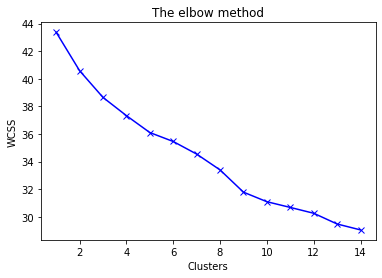

In [48]:
### Find best fitted cluster number with elbow method

wcss = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(se_clust)
    wcss.append(kmeans.inertia_)

#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 15), wcss, 'bx-')
plt.title('The elbow method')        
plt.xlabel('Clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [49]:
### it seems like after 9 clusters the inertia drops in a less steep manner
clusters = 9
# run k-means clustering
kmeans = KMeans(n_clusters = clusters, random_state=0).fit(se_clust)


kmeans.labels_[0:10] 

array([1, 4, 4, 0, 0, 4, 3, 4, 4, 4], dtype=int32)

In [50]:
commondf['clusters'] = kmeans.labels_

In [51]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [52]:
#Merge the data frame with the initial dataFrame on the common feature (School/SKOLA)
se_final = df

se_final = se_final.join(commondf.set_index('School'), on='SKOLA').dropna(axis = 0)
se_final.clusters = se_final.clusters.astype('int32')
se_final.head()

,SDO,REGI,SKOLA,Arskurs,Elevanal19,X_North,Y_East,CommonVenue1,CommonVenue2,CommonVenue3,CommonVenue4,CommonVenue5,clusters
0,Bromma,Kommunala grundskolor,Abrahamsbergsskolan,F-9,678,59.334960,17.950383,Grocery Store,Gym / Fitness Center,Indian Restaurant,Metro Station,Pizza Place,1
1,Norrmalm,Kommunala grundskolor,Adolf Fredriks Musikklasser,4-9,1120,59.337428,18.050868,Café,Hotel,Park,Scandinavian Restaurant,Art Gallery,4
2,Bromma,Kommunala grundskolor,Adolfsbergsskolan,F-1,132,59.357645,17.953585,Bus Stop,Clothing Store,Electronics Store,Furniture / Home Store,Men's Store,4
3,Rinkeby-Kista,Fristående grundskolor,Akademiska skolan i Kista-Husby,F-6,35,59.411259,17.928031,Bus Station,Bus Stop,Fast Food Restaurant,Park,Plaza,0
4,Rinkeby-Kista,Kommunala grundskolor,Akalla grundskola F-9,F-9,498,59.415862,17.910269,Farm,Bus Stop,Candy Store,Golf Course,Grocery Store,0


In [53]:
se_final.shape

(374, 13)

In [54]:
# create map to visualize the clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_final['X_North'], se_final['Y_East'], se_final['SKOLA'], se_final['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# For each cluster find the most common venues per CommonVenue1-5

For example: for cluster 1 find the most common (higher number of counts) venue for the MostCommonVenue 1 - 5. In that way we can ee which are the most common venues per cluster for each of the 5 Common Venues categories

# Get some insights

In [55]:
def insights(data, cluster, venue_list):
    print('For cluster {} the most common venues are:'.format(cluster))
    print('-----------------------------')
    
    venues_list = []
    common = []  # the most frequent venue among each cluster
    
    for venue in venue_list:
        print(venue)
        print(data.loc[data['clusters'] == cluster, venue].value_counts()[:1]) # get the most frequent venues per cluster
        print('-----------------------------')
        
        most_common = data.loc[data['clusters'] == cluster, venue].value_counts()[:1].index.to_list()
        common.extend(most_common)
        
    common.insert(0, cluster)
    meanstud = data.loc[data['clusters'] == cluster, 'Elevanal19'].mean()
    clustersize = data.loc[data['clusters'] == cluster, :].shape[0]
    
    common.append(meanstud)
    common.append(clustersize)
    
    venues_list.append(common)
        
    
    return venues_list

    
    

In [56]:
print('INSIGHTS')
print('-----------------------------')
venues_list = []
for i in range(9):
    ven_list = insights(se_final, i, se_final.columns[7:-1])
    venues_list.extend(ven_list)
     
    
print('DONE')
    

INSIGHTS
-----------------------------
For cluster 0 the most common venues are:
-----------------------------
CommonVenue1
Bakery    7
Name: CommonVenue1, dtype: int64
-----------------------------
CommonVenue2
Grocery Store    9
Name: CommonVenue2, dtype: int64
-----------------------------
CommonVenue3
Gym / Fitness Center    6
Name: CommonVenue3, dtype: int64
-----------------------------
CommonVenue4
Park    7
Name: CommonVenue4, dtype: int64
-----------------------------
CommonVenue5
Accessories Store    11
Name: CommonVenue5, dtype: int64
-----------------------------
For cluster 1 the most common venues are:
-----------------------------
CommonVenue1
Pizza Place    20
Name: CommonVenue1, dtype: int64
-----------------------------
CommonVenue2
Pizza Place    7
Name: CommonVenue2, dtype: int64
-----------------------------
CommonVenue3
Pizza Place    10
Name: CommonVenue3, dtype: int64
-----------------------------
CommonVenue4
Accessories Store    3
Name: CommonVenue4, dtype: in

## DataFrame of the most common venues among schools of each cluster for each Common Venue category

In [57]:
venuedf = pd.DataFrame([venue_list for venue_list in venues_list])
venuedf.columns = ['Cluster', 'MostFreqVen1', 'MostFreqVen2', 'MostFreqVen3', 'MostFreqVen4', 'MostFreqVen5', 'MeanNumStudents', 'ClusterSize']    


In [58]:
venuedf.set_index('Cluster', inplace =True)
venuedf

,MostFreqVen1,MostFreqVen2,MostFreqVen3,MostFreqVen4,MostFreqVen5,MeanNumStudents,ClusterSize
Cluster,,,,,,,
0,Bakery,Grocery Store,Gym / Fitness Center,Park,Accessories Store,362.582090,67
1,Pizza Place,Pizza Place,Pizza Place,Accessories Store,Accessories Store,429.727273,44
2,Bus Stop,Café,Park,Park,Scandinavian Restaurant,238.733333,15
3,Bus Stop,Convenience Store,Grocery Store,Metro Station,Accessories Store,318.312500,16
4,Café,Café,Bakery,Bakery,Gym / Fitness Center,328.556561,221
5,Bus Stop,Bus Stop,Accessories Store,Accessories Store,Advertising Agency,497.714286,7
6,Harbor / Marina,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,153.000000,1
7,Deli / Bodega,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,1204.000000,1
8,Tram Station,Accessories Store,Advertising Agency,Advertising Agency,Amphitheater,398.500000,2


### Result interpretation

In [59]:
import seaborn as sns

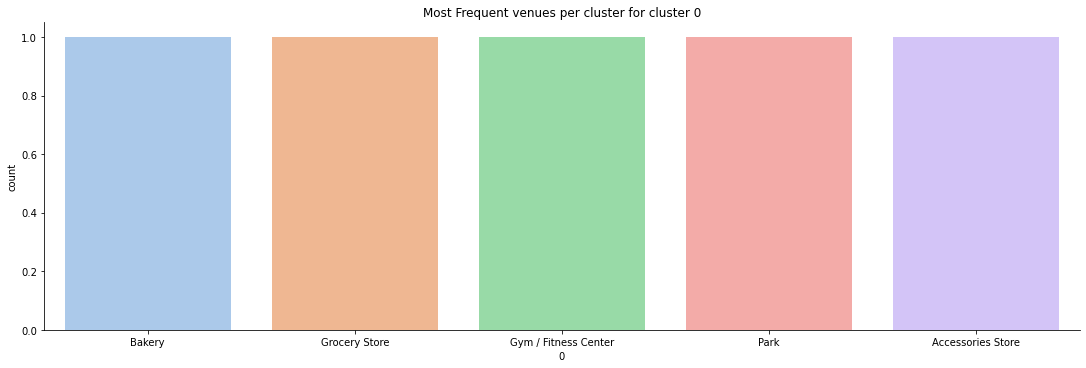

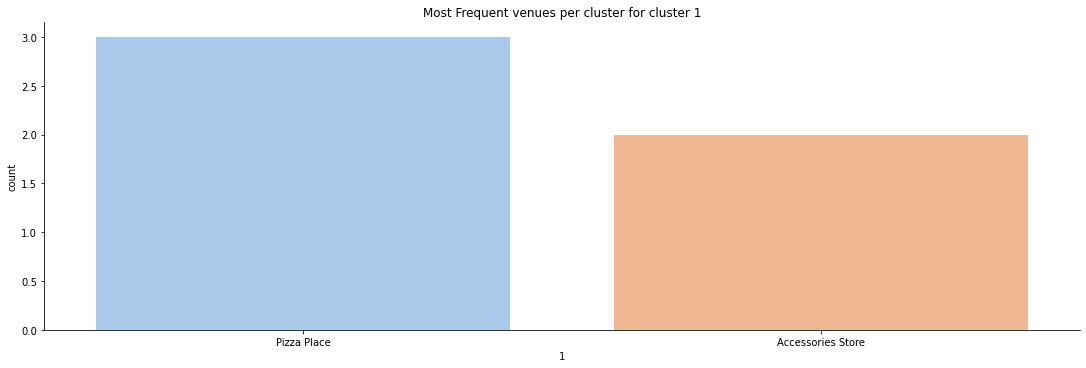

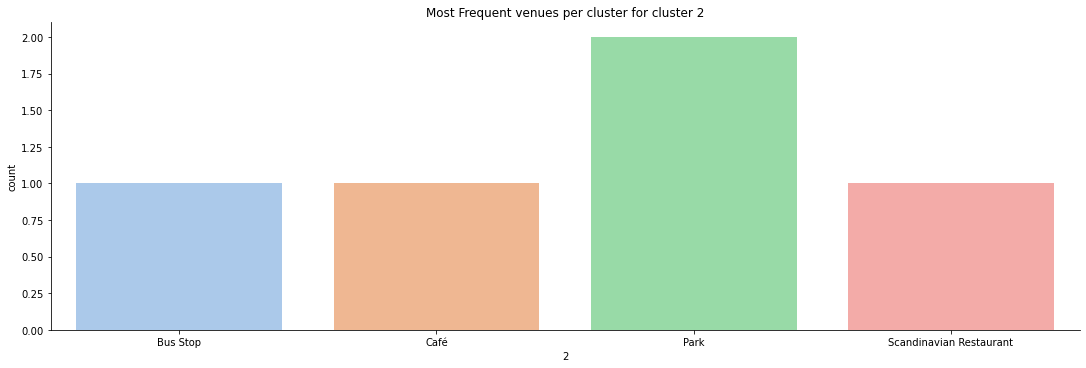

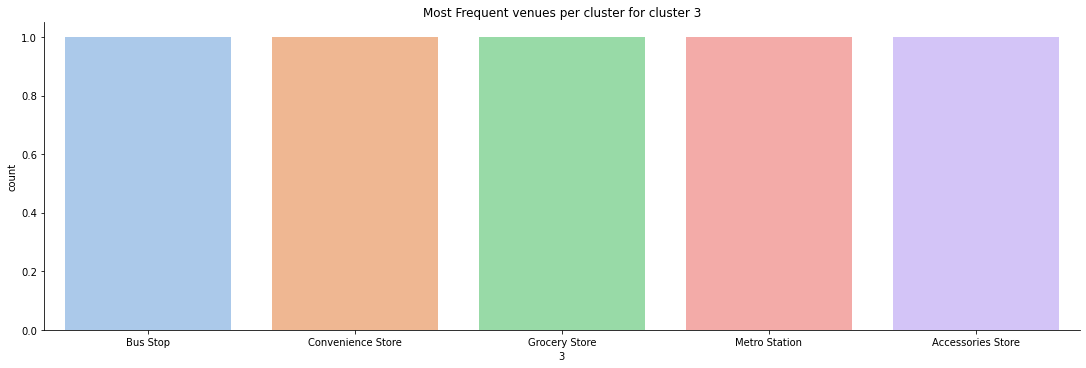

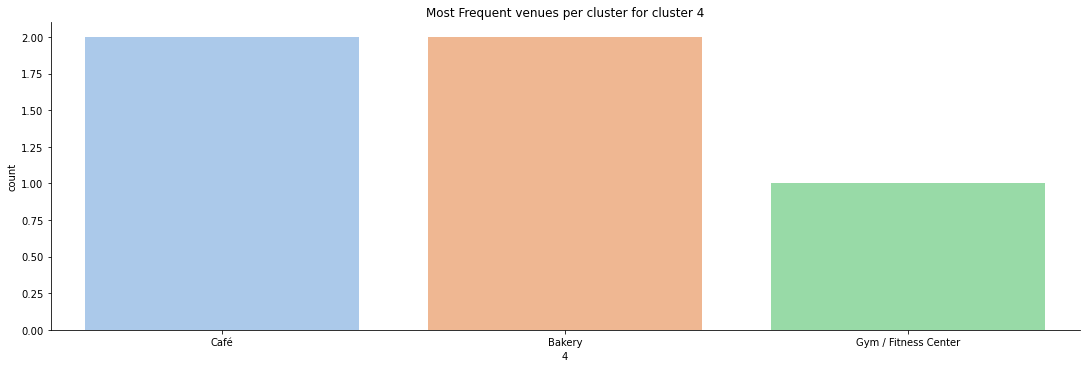

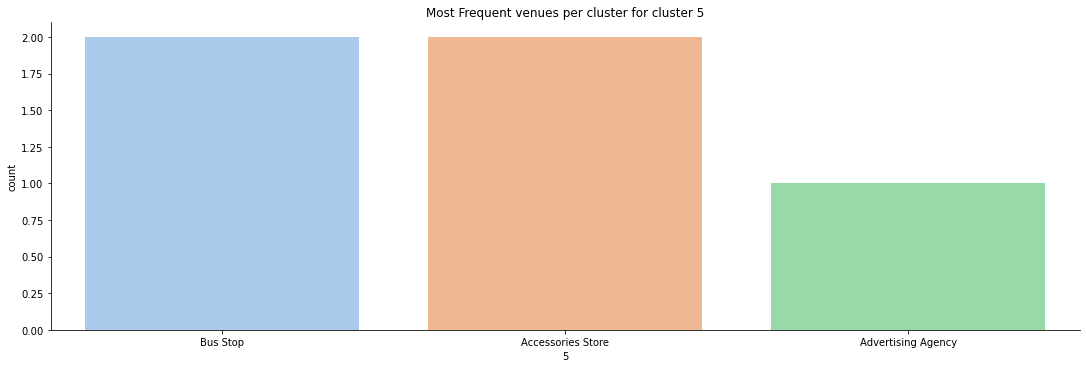

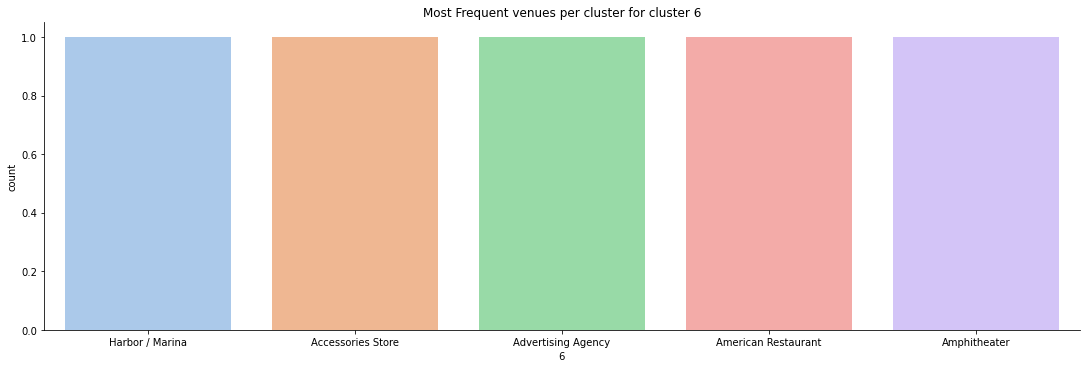

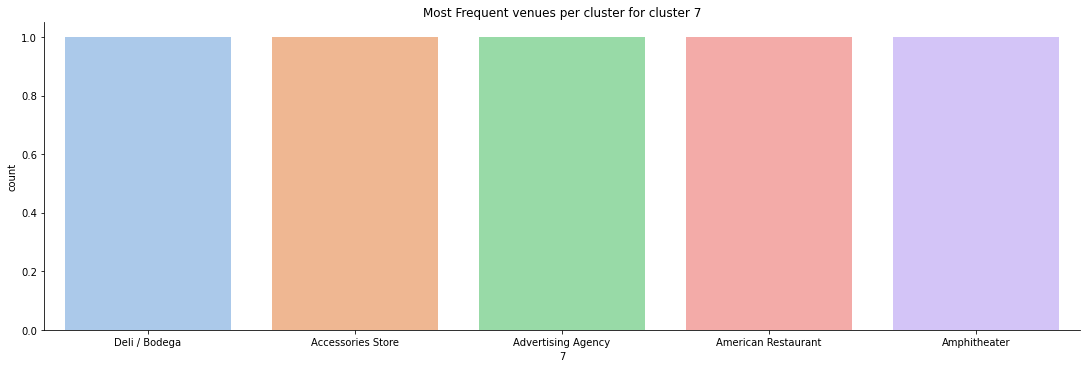

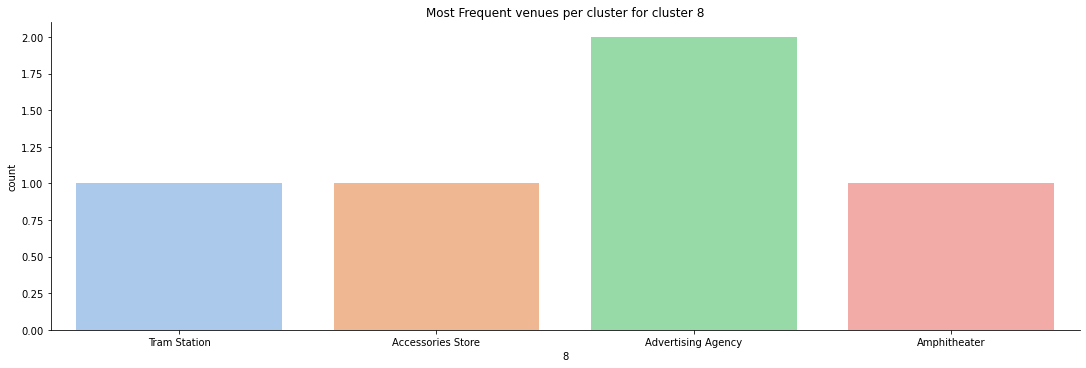

In [60]:
for venue in venuedf.iloc[:,:-1].T.columns:
  
    
    sns.catplot(x=venue, kind="count", palette="pastel", data=venuedf.iloc[:,:-2].T,
               height = 5, aspect = 3)
    
    plt.title('Most Frequent venues per cluster for cluster {}'.format(venue))
    #plt.savefig('Clust{}.png'.format(venue))

### Correlation between variables

In [61]:
ven = venuedf.copy()

In [62]:
for cols in ven.columns[:-2]:
    ven[cols] = ven[cols].astype('category').cat.codes

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [64]:
scal = MinMaxScaler()

In [65]:
ven.MeanNumStudents = scal.fit_transform(ven.MeanNumStudents.values.reshape(-1,1))

In [66]:
ven

,MostFreqVen1,MostFreqVen2,MostFreqVen3,MostFreqVen4,MostFreqVen5,MeanNumStudents,ClusterSize
Cluster,,,,,,,
0,0,4,4,5,0,0.199412,67
1,5,5,6,0,0,0.263299,44
2,1,2,5,5,4,0.081573,15
3,1,3,3,4,0,0.157291,16
4,2,2,2,3,3,0.167038,221
5,1,1,0,0,1,0.327987,7
6,4,0,1,2,2,0.000000,1
7,3,0,1,2,2,1.000000,1
8,6,0,1,1,2,0.233587,2


In [67]:
ven.corr()

,MostFreqVen1,MostFreqVen2,MostFreqVen3,MostFreqVen4,MostFreqVen5,MeanNumStudents,ClusterSize
MostFreqVen1,1.000000,-0.278375,-0.110390,-0.659893,0.051873,0.085029,-0.201720
MostFreqVen2,-0.278375,1.000000,0.842451,0.226066,-0.547965,-0.276911,0.296557
MostFreqVen3,-0.110390,0.842451,1.000000,0.366223,-0.160335,-0.288443,0.123720
MostFreqVen4,-0.659893,0.226066,0.366223,1.000000,0.215778,-0.259541,0.207402
MostFreqVen5,0.051873,-0.547965,-0.160335,0.215778,1.000000,-0.047688,0.193308
MeanNumStudents,0.085029,-0.276911,-0.288443,-0.259541,-0.047688,1.000000,-0.191926
ClusterSize,-0.201720,0.296557,0.123720,0.207402,0.193308,-0.191926,1.000000


We observe a weak correlation among features. It seems that the Number of enrolled students is not significantly affected by the type of most common venues